#Import Library

In [ ]:
import os
import random
import shutil
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the source and destination directories
data_dir = "/content/drive/MyDrive/ML/data/leaf"
dest_dir = "/content/drive/MyDrive/data"

#Pre-processing

In [ ]:
# Define the train-test split ratio (e.g., 60% train, 20% test 20* validasi)
split_ratio = 0.2
validation_split = 0.2

In [ ]:
# Iterate through each subfolder in the source directory
for root, dirs, files in os.walk(data_dir):
    if files:  # Only process subfolders containing files
        # Create corresponding subfolders in the destination directory
        dest_root = os.path.join(dest_dir, os.path.relpath(root, data_dir))
        os.makedirs(os.path.join(dest_root, 'train'), exist_ok=True)  # Create train directory
        os.makedirs(os.path.join(dest_root, 'test'), exist_ok=True)   # Create test directory

        # Split the files into train and test sets
        train_files, test_files = train_test_split(files, test_size=split_ratio, random_state=42)

        # Copy the train and test files to their respective subfolders
        for file in train_files:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(dest_root, 'train', file)
            shutil.copy2(src_path, dest_path)

        for file in test_files:
            src_path = os.path.join(root, file)
            dest_path = os.path.join(dest_root, 'test', file)
            shutil.copy2(src_path, dest_path)

print("Data splitting completed.")

Data splitting completed.


#Data Transform

In [ ]:
# Define data transformations
transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create a dataset using ImageFolder
dataset = ImageFolder(root=data_dir, transform=transform)

# Create a data loader for batch processing
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Define the root directory where your data is located
data_root = "/content/drive/MyDrive/ML/data/leaf"  # Your dataset root directory

# Define the transformation to apply to your images
transform = Compose([
    Resize((224, 224)),  # Resize the images to a consistent size
    ToTensor(),           # Convert images to PyTorch tensors
    Normalize(            # Normalize the pixel values
        mean=[0.485, 0.456, 0.406],  # Mean values for RGB channels
        std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
    )
])


In [ ]:
# Create a dataset from your image folder with subfolders
dataset = ImageFolder(root=data_root, transform=transform)

In [ ]:
# Calculate the sizes for the training and validation sets
num_data = len(dataset)
num_valid = int(validation_split * num_data)
num_train = num_data - num_valid

In [ ]:
# Split the dataset into training and validation sets
train_dataset, valid_dataset = random_split(dataset, [num_train, num_valid])

#Data Loader

In [ ]:
# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

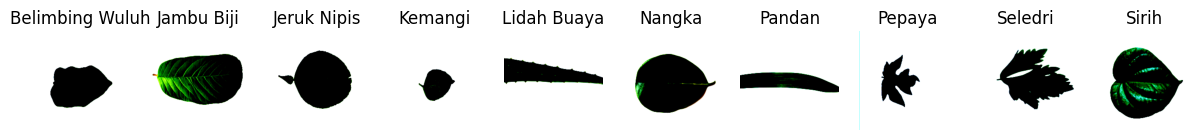

In [ ]:
# Function to display one sample image from each unique class
def show_one_sample_per_class(dataset):
    num_classes = len(dataset.classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

    for class_idx, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_idx]
        random_idx = np.random.choice(class_indices)
        sample_image, sample_label = dataset[random_idx]

        ax = axes[class_idx]
        ax.imshow(np.transpose(sample_image, (1, 2, 0)))  # Transpose to (H, W, C)
        ax.set_title(class_name)
        ax.axis('off')

    plt.show()

# Display one sample image from each unique class in the dataset
show_one_sample_per_class(dataset)

In [ ]:
# Function to get the default device (CPU or GPU)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
# Get the default device
device = get_default_device()

#Arsitektur CNN

In [ ]:
# CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=32 * 56 * 56, out_features=128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the model
model = SimpleCNN(num_classes=10)  # Number of classes in the dataset

# Print model summary
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#Pelatihan Model

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Move the model to the appropriate device (CPU or GPU)
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Lists to store training and validation losses
train_losses = []
valid_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
valid_accuracies = []

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] => '
          f'Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%')


Epoch [1/10] => Train Loss: 0.0009, Valid Loss: 0.7575, Train Accuracy: 100.00%, Valid Accuracy: 82.57%
Epoch [2/10] => Train Loss: 0.0007, Valid Loss: 0.7716, Train Accuracy: 100.00%, Valid Accuracy: 82.14%
Epoch [3/10] => Train Loss: 0.0006, Valid Loss: 0.7827, Train Accuracy: 100.00%, Valid Accuracy: 82.29%
Epoch [4/10] => Train Loss: 0.0005, Valid Loss: 0.7992, Train Accuracy: 100.00%, Valid Accuracy: 82.43%
Epoch [5/10] => Train Loss: 0.0004, Valid Loss: 0.8052, Train Accuracy: 100.00%, Valid Accuracy: 82.29%
Epoch [6/10] => Train Loss: 0.0004, Valid Loss: 0.8186, Train Accuracy: 100.00%, Valid Accuracy: 82.14%
Epoch [7/10] => Train Loss: 0.0003, Valid Loss: 0.8248, Train Accuracy: 100.00%, Valid Accuracy: 82.14%
Epoch [8/10] => Train Loss: 0.0003, Valid Loss: 0.8361, Train Accuracy: 100.00%, Valid Accuracy: 82.00%
Epoch [9/10] => Train Loss: 0.0003, Valid Loss: 0.8464, Train Accuracy: 100.00%, Valid Accuracy: 82.14%
Epoch [10/10] => Train Loss: 0.0002, Valid Loss: 0.8514, Train A

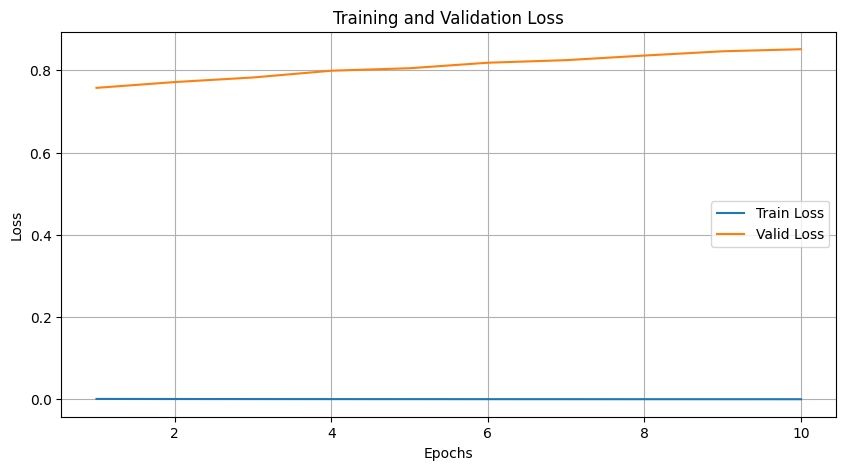

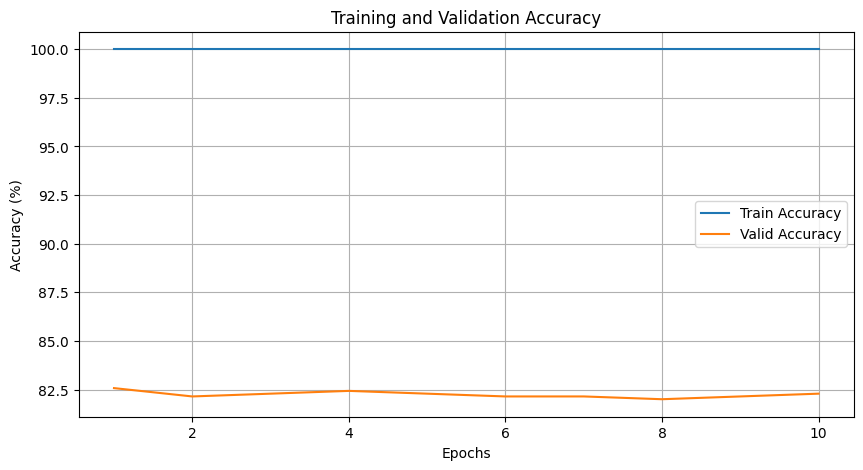

Training completed.


In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Training completed.")